# Introduction
Le filtrage collaboratif basé sur les éléments est également appelé filtrage collaboratif élément-élément. Il s'agit d'un type d'algorithme de système de recommandation qui utilise la similarité des articles pour formuler des recommandations de produits.

Ici, nous parlerons de

- Qu’est-ce que le filtrage collaboratif basé sur les éléments (élément-élément) ?

- Comment créer une matrice utilisateur-produit ?

- Comment identifier des objets similaires ?

- Comment classer les éléments pour la recommandation ?

# Fonctionnement


Tout d’abord, comprenons comment fonctionne le filtrage collaboratif basé sur les éléments.

Le filtrage collaboratif basé sur les éléments émet des recommandations basées sur les interactions utilisateur-produit passées. L’hypothèse derrière l’algorithme est que les utilisateurs aiment les produits similaires et n’aiment pas les produits similaires, ils attribuent donc des notes similaires à des produits similaires.

L'algorithme de filtrage collaboratif basé sur les éléments comporte généralement les étapes suivantes :

- Calculez les scores de similarité des éléments en fonction de toutes les évaluations des utilisateurs.

- Identifiez les n éléments les plus similaires à l’élément qui vous intéresse.

- Calculez le score moyen pondéré des éléments les plus similaires par l'utilisateur.

- Classez les éléments en fonction de leur score et choisissez les n meilleurs éléments à recommander.

# import des librairies

In [1]:
import pandas as pd
import os
import random
from random import choice
import numpy as np

import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# import des données

In [2]:

from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
review = pd.read_csv('/content/gdrive/MyDrive/scrap/reviews_data.csv')
attract = pd.read_csv('/content/gdrive/MyDrive/scrap/attractions.csv')

# Preprocessing

In [ ]:
review.head(5)

,Unnamed: 0,image_user,user,info_user,type_review,review_date,review,rating,attraction_id,user_id
0,0,https://dynamic-media-cdn.tripadvisor.com/medi...,bucketlisttravel,"Saint Paul, MN11 contributions",So lively!!,"January 6, 2024",Lively people. Happy kids. Beautiful skyline. ...,5.0,0,0
1,1,https://dynamic-media-cdn.tripadvisor.com/medi...,WPLandry,"Fairfax, VA545 contributions",Beautiful & spacious,"January 6, 2024",Central Park is an amazing escape from the bus...,5.0,0,1
2,2,https://dynamic-media-cdn.tripadvisor.com/medi...,Rumzzz,"Irving, TX77 contributions",Spectacular,"January 6, 2024",One can never get enough of Central Park - the...,5.0,0,2
3,3,https://dynamic-media-cdn.tripadvisor.com/medi...,A Ruiz,"Lahaina, HI56 contributions",Awesome experience!,"December 30, 2023",Carriage ride around the park with historical ...,5.0,0,3
4,4,https://dynamic-media-cdn.tripadvisor.com/medi...,BeakerTX,"San Antonio, TX572 contributions",It's a park!,"December 28, 2023",Nice family stroll through the southern part o...,5.0,0,4


In [ ]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13027 entries, 0 to 13026
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     13027 non-null  int64  
 1   image_user     11840 non-null  object 
 2   user           13027 non-null  object 
 3   info_user      13027 non-null  object 
 4   type_review    13027 non-null  object 
 5   review_date    13027 non-null  object 
 6   review         13027 non-null  object 
 7   rating         13027 non-null  float64
 8   attraction_id  13027 non-null  int64  
 9   user_id        13027 non-null  int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 1017.9+ KB


In [ ]:
review.shape

(13027, 10)

In [ ]:
review.isnull().sum()

Unnamed: 0          0
image_user       1187
user                0
info_user           0
type_review         0
review_date         0
review              0
rating              0
attraction_id       0
user_id             0
dtype: int64

In [ ]:
review.nunique()

Unnamed: 0       13027
image_user        3725
user              9048
info_user         7874
type_review      11248
review_date       3035
review           12721
rating               5
attraction_id      104
user_id           9048
dtype: int64

In [ ]:
attract.head(5)

,Unnamed: 0,attraction_id,country,province,city,lien_detail,image,category,nbre_review,address,name,rating,price
0,0,0,United States,New York (NY),New York City,https://www.tripadvisor.com/Attraction_Review-...,['https://dynamic-media-cdn.tripadvisor.com/me...,1. Central Park,134000,"{'lat': 40.71304703, 'lng': -74.00723267}",Points of Interest & Landmarks • Parks,4.5,200.00
1,1,1,United States,New York (NY),New York City,https://www.tripadvisor.com/Attraction_Review-...,['https://dynamic-media-cdn.tripadvisor.com/me...,2. The National 9/11 Memorial & Museum,96883,"{'lat': 40.71304703, 'lng': -74.00723267}",Speciality Museums • Historic Sites,4.5,33.00
2,2,2,United States,New York (NY),New York City,https://www.tripadvisor.com/Attraction_Review-...,['https://dynamic-media-cdn.tripadvisor.com/me...,3. The Metropolitan Museum of Art,55184,"{'lat': 40.78384018, 'lng': -73.96555328}",Points of Interest & Landmarks • Art Museums,5.0,126.14
3,3,3,United States,New York (NY),New York City,https://www.tripadvisor.com/Attraction_Review-...,['https://dynamic-media-cdn.tripadvisor.com/me...,4. Empire State Building,94920,"{'lat': 40.74880981, 'lng': -73.98639679}",Points of Interest & Landmarks • Architectural...,4.5,48.00
4,4,4,United States,New York (NY),New York City,https://www.tripadvisor.com/Attraction_Review-...,['https://dynamic-media-cdn.tripadvisor.com/me...,5. The High Line,62997,"{'lat': 40.72782516, 'lng': -73.99477386}",Parks • Scenic Walking Areas,4.5,88.00


In [ ]:
attract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     104 non-null    int64  
 1   attraction_id  104 non-null    int64  
 2   country        104 non-null    object 
 3   province       104 non-null    object 
 4   city           104 non-null    object 
 5   lien_detail    104 non-null    object 
 6   image          104 non-null    object 
 7   category       104 non-null    object 
 8   nbre_review    104 non-null    int64  
 9   address        104 non-null    object 
 10  name           104 non-null    object 
 11  rating         104 non-null    float64
 12  price          104 non-null    float64
dtypes: float64(2), int64(3), object(8)
memory usage: 10.7+ KB


In [ ]:
attract.shape

(150, 13)

In [4]:
attract = attract[0:104]

In [ ]:
attract.isnull().sum()

Unnamed: 0       0
attraction_id    0
country          0
province         0
city             0
lien_detail      0
image            0
category         0
nbre_review      0
address          0
name             0
rating           0
price            0
dtype: int64

In [ ]:
attract.nunique()

Unnamed: 0       104
attraction_id    104
country            1
province           1
city               1
lien_detail      104
image            104
category         104
nbre_review      102
address           24
name              53
rating             3
price             59
dtype: int64

In [5]:
data = review.merge(attract, on='attraction_id')

In [ ]:
data.head(2)

,Unnamed: 0_x,image_user,user,info_user,type_review,review_date,review,rating_x,attraction_id,user_id,...,province,city,lien_detail,image,category,nbre_review,address,name,rating_y,price
0,0,https://dynamic-media-cdn.tripadvisor.com/medi...,bucketlisttravel,"Saint Paul, MN11 contributions",So lively!!,"January 6, 2024",Lively people. Happy kids. Beautiful skyline. ...,5.0,0,0,...,New York (NY),New York City,https://www.tripadvisor.com/Attraction_Review-...,['https://dynamic-media-cdn.tripadvisor.com/me...,1. Central Park,134000,"{'lat': 40.71304703, 'lng': -74.00723267}",Points of Interest & Landmarks • Parks,4.5,200.0
1,1,https://dynamic-media-cdn.tripadvisor.com/medi...,WPLandry,"Fairfax, VA545 contributions",Beautiful & spacious,"January 6, 2024",Central Park is an amazing escape from the bus...,5.0,0,1,...,New York (NY),New York City,https://www.tripadvisor.com/Attraction_Review-...,['https://dynamic-media-cdn.tripadvisor.com/me...,1. Central Park,134000,"{'lat': 40.71304703, 'lng': -74.00723267}",Points of Interest & Landmarks • Parks,4.5,200.0


In [ ]:
user_counts = data['user_id'].value_counts()
# Obtenir l'ID du user ayant le plus de notes
user_id_max_notes = user_counts.idxmax()

print("L'ID du user ayant le plus de notes :", user_id_max_notes)

L'ID du user ayant le plus de notes : 285


In [ ]:
user_counts

285     80
999     62
138     41
283     36
634     28
        ..
3639     1
3638     1
3637     1
3636     1
9047     1
Name: user_id, Length: 9048, dtype: int64

# Analyse exploiratoire des données

In [6]:
# Aggregate by attraction
agg_ratings = data.groupby('attraction_id').agg(mean_rating = ('rating_x', 'mean'),
                                                number_of_ratings = ('rating_x', 'count')).reset_index()

In [ ]:
agg_ratings

,attraction_id,mean_rating,number_of_ratings
0,0,4.709091,110
1,1,4.746154,130
2,2,4.513333,150
3,3,4.158333,120
4,4,4.650000,120
...,...,...,...
99,99,4.300000,140
100,100,4.292035,113
101,101,4.635714,140
102,102,4.420000,100


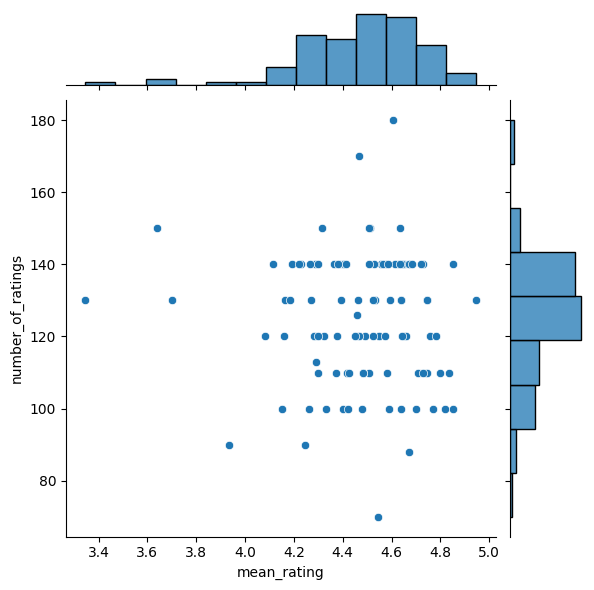

In [ ]:
# Visulization
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings)

In [ ]:
print('The ratings dataset has', data['user_id'].nunique(), 'unique users')

# Number of attractions
print('The ratings dataset has', data['attraction_id'].nunique(), 'unique attractions')

# Number of ratings
print('The ratings dataset has', data['rating_x'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(data['rating_x'].unique()))

The ratings dataset has 9048 unique users
The ratings dataset has 104 unique movies
The ratings dataset has 5 unique ratings
The unique ratings are [1.0, 2.0, 3.0, 4.0, 5.0]


In [ ]:
data[['user_id', 'attraction_id']].duplicated().sum()  #491 personnes on noté la meme attraction plus d'une fois

491

# Data normalization

In [7]:
data_aggregated = data.groupby(['user_id', 'attraction_id']).agg({'rating_x': 'mean'}).reset_index()
user_rating_df = data_aggregated.pivot(index='attraction_id', columns='user_id', values='rating_x')

In [8]:
data_aggregated.shape

(12536, 3)

In [9]:
user_rating_df

user_id,0,1,2,3,4,5,6,7,8,9,...,9038,9039,9040,9041,9042,9043,9044,9045,9046,9047
attraction_id,,,,,,,,,,,,,,,,,,,,,
0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
norm_user_rating = user_rating_df.fillna(0) / 5.0
trY = norm_user_rating.values

In [ ]:
trY

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.]])

La matrice de notes trX est de forme (104, 9048), donc 9048 utilisateurs notent 104 attractions.

In [ ]:
from collections import Counter
unique_ratings_count = dict(Counter(np.count_nonzero(trY, axis=1)))
unique_ratings_count

{109: 4,
 120: 7,
 150: 2,
 119: 8,
 140: 7,
 130: 4,
 108: 2,
 98: 2,
 100: 6,
 110: 5,
 90: 1,
 139: 7,
 89: 1,
 49: 1,
 159: 1,
 138: 2,
 147: 1,
 116: 3,
 118: 1,
 148: 1,
 137: 7,
 136: 2,
 126: 1,
 99: 1,
 134: 1,
 127: 3,
 128: 7,
 70: 1,
 20: 1,
 106: 1,
 131: 1,
 97: 1,
 132: 1,
 107: 1,
 96: 2,
 135: 1,
 125: 1,
 129: 2,
 121: 1,
 101: 1,
 87: 1}

In [13]:
len(trY[1])

9048

# Modéle

itteration: 1 Epoch: 1 batch #: 4 sample #: 5 reconstruction error: 0.374899
itteration: 2 Epoch: 1 batch #: 9 sample #: 5 reconstruction error: 0.314411
itteration: 3 Epoch: 1 batch #: 14 sample #: 5 reconstruction error: 0.299755
itteration: 4 Epoch: 1 batch #: 19 sample #: 5 reconstruction error: 0.282560
itteration: 5 Epoch: 1 batch #: 24 sample #: 5 reconstruction error: 0.252319
itteration: 6 Epoch: 1 batch #: 29 sample #: 5 reconstruction error: 0.266153
itteration: 7 Epoch: 1 batch #: 34 sample #: 5 reconstruction error: 0.240723
itteration: 8 Epoch: 1 batch #: 39 sample #: 5 reconstruction error: 0.228317
itteration: 9 Epoch: 1 batch #: 44 sample #: 5 reconstruction error: 0.226379
itteration: 10 Epoch: 1 batch #: 49 sample #: 5 reconstruction error: 0.220622
itteration: 11 Epoch: 1 batch #: 54 sample #: 5 reconstruction error: 0.212135
itteration: 12 Epoch: 1 batch #: 59 sample #: 5 reconstruction error: 0.212286
itteration: 13 Epoch: 1 batch #: 64 sample #: 5 reconstruction 

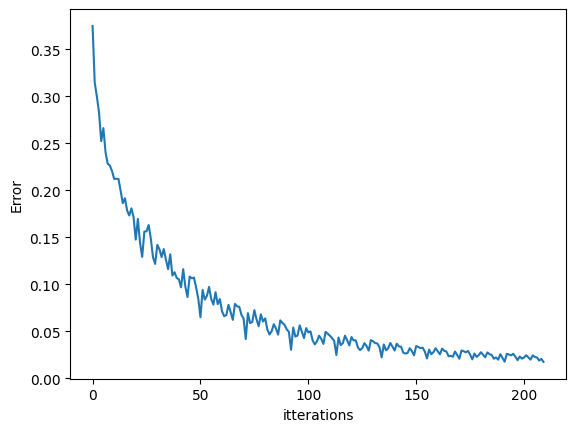

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Définir la fonction hidden_layer
def hidden_layer(v, w, b):
    return tf.nn.sigmoid(tf.matmul(v, w) + b)

# Définir la fonction reconstructed_output
def reconstructed_output(h, w, b):
    return tf.nn.sigmoid(tf.matmul(h, tf.transpose(w)) + b)


# Définir la fonction d'erreur
def error(v0, v1):
    return tf.reduce_mean(tf.square(v0 - v1))

# Définir les paramètres
epochs = 10
batchsize = 5
errors = []
weights = []  # Correction: remplacer 500 par une liste vide []
k = 1
alpha = 0.02

# Définir le nombre d'unités pour la couche visible et cachée
visible_units = len(trY[0])  # Remplacez ceci par la taille de votre ensemble de données
hidden_units = trY.shape[0]

# Initialiser les poids et les biais
w = tf.Variable(tf.random.normal([visible_units, hidden_units], 0.01), dtype=tf.float32)
vb = tf.Variable(tf.zeros([visible_units]), dtype=tf.float32)
hb = tf.Variable(tf.zeros([hidden_units]), dtype=tf.float32)

# Convertir trX en float32
trY = np.float32(trY)

# Créer le dataset TensorFlow
train_ds = tf.data.Dataset.from_tensor_slices(trY).batch(batchsize)

# Entraînement du modèle
j = 0
for epoch in range(epochs):
    batch_number = 0
    for batch_x in train_ds:
        j +=1
        for i_sample in range(len(batch_x)):
          for _ in range(k):

            v0_state = batch_x[i_sample]
            v0_state_reshaped = tf.reshape(v0_state, [1, -1])  # Redimensionner v0_state en une ligne (1D)

            h0_state = hidden_layer(v0_state_reshaped, w, hb)
            v1_state = reconstructed_output(h0_state, w, vb)
            h1_state = hidden_layer(v1_state, w, hb)

            delta_w = tf.matmul(tf.transpose(v0_state_reshaped), h0_state) - tf.matmul(tf.transpose(v1_state), h1_state)

            w = w + alpha * delta_w

            vb = vb + alpha * tf.reduce_mean(v0_state - v1_state, 0)
            hb = hb + alpha * tf.reduce_mean(h0_state - h1_state, 0)
            v0_state = v1_state

            if i_sample == len(batch_x) - 1:
                err = error(v0_state_reshaped, v1_state)  # Utiliser v0_state_reshaped ici
                errors.append(err)
                weights.append(w.numpy())

                print('itteration: %d' % (j),
                    'Epoch: %d' % (epoch + 1),
                      "batch #: %i" % batch_number,
                      "sample #: %i" % (i_sample + 1),
                      'reconstruction error: %f' % err)


            batch_number += 1

# Tracer les erreurs
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('itterations')
plt.show()


In [21]:
filename = data

In [26]:
np.save('w0.npy', w)
np.save('vb.npy', vb)
np.save('hb.npy', hb)

In [16]:
itemid = 0

In [20]:
trY[itemid-1]

array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)

In [24]:
np.save('trY.npy', trY)

In [ ]:
inputUser = trY[itemid-1].reshape(1, -1)
inputUser = tf.convert_to_tensor(trY[itemid - 1], "float32")
v0 = inputUser
print(v0)

tf.Tensor([0. 0. 0. ... 1. 1. 1.], shape=(9048,), dtype=float32)


In [ ]:

# Calculez la sortie du modèle pour l'attraction spécifique
hh0 = tf.nn.sigmoid(tf.matmul([v0], w) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(w)) + vb)

# Recommandations (correspondent aux produits)
recommendations = hh0.numpy().flatten()

# Affichez les recommandations pour l'utilisateur spécifique
print("Recommandations pour l'utilisateur {}: {}".format(itemid, recommendations))

Recommandations pour l'utilisateur 0: [1.9118600e-12 2.7754305e-14 3.6349057e-14 2.0730093e-09 7.6020994e-09
 4.9975808e-14 5.7727313e-11 1.5479682e-07 7.8271443e-12 5.4705128e-13
 3.3889969e-10 3.5284191e-13 1.9296384e-09 3.4209644e-09 1.3348849e-15
 8.1641383e-10 3.3828371e-13 4.2514148e-12 9.8928028e-01 9.9998873e-01
 3.1210976e-09 1.4984475e-07 2.5256038e-05 7.6704064e-06 3.6262382e-09
 1.5711348e-10 2.1002199e-06 1.6027377e-07 1.6582846e-10 8.0146547e-06
 2.5473521e-12 2.0208893e-10 3.8858792e-07 2.0079785e-11 9.9814184e-09
 9.4136974e-09 8.9604626e-05 1.2371132e-10 1.1102760e-07 6.5445099e-10
 3.3044775e-11 5.6032310e-14 2.4622429e-06 3.5497963e-10 7.5096097e-05
 1.1073761e-06 4.6719601e-05 3.7206692e-04 7.7311178e-08 1.0042899e-10
 1.9908450e-06 6.2221238e-07 7.1289799e-07 2.0834168e-04 1.0350332e-07
 3.3062079e-04 2.6802022e-17 2.6431280e-06 1.9603620e-07 6.4256964e-09
 2.0751789e-11 1.5073432e-08 8.4590016e-11 6.5184236e-10 5.2275749e-12
 6.6736573e-01 4.9989171e-07 1.0828854e

In [ ]:
attraction_score = attract[attract['attraction_id'].isin(user_rating_df.columns)]

In [ ]:

attraction_score = attraction_score.assign(recommandationScore = recommendations)
attraction_score.sort_values(['recommandationScore'], ascending=False).head(10)

,Unnamed: 0,attraction_id,country,province,city,lien_detail,image,category,nbre_review,address,name,rating,price,recommandationScore
72,72,72,United States,New York (NY),New York City,https://www.tripadvisor.com/Attraction_Review-...,['https://dynamic-media-cdn.tripadvisor.com/me...,73. Merchant's House Museum,318,"{'lat': 40.71304703, 'lng': -74.00723267}",History Museums,4.5,64.0,0.999999
19,19,19,United States,New York (NY),New York City,https://www.tripadvisor.com/Attraction_Review-...,['https://dynamic-media-cdn.tripadvisor.com/me...,20. The Museum of Modern Art (MoMA),18346,"{'lat': 40.75992584, 'lng': -73.98041534}",Art Museums,4.5,30.0,0.999989
103,103,103,United States,New York (NY),New York City,https://www.tripadvisor.com/Attraction_Review-...,['https://dynamic-media-cdn.tripadvisor.com/me...,104. Union Square Green Market,355,No Address Found,Flea & Street Markets,4.5,54.0,0.999979
18,18,18,United States,New York (NY),New York City,https://www.tripadvisor.com/Attraction_Review-...,['https://dynamic-media-cdn.tripadvisor.com/me...,19. American Museum of Natural History,26168,"{'lat': 40.78846359, 'lng': -73.98106384}",Natural History Museums,4.5,28.0,0.989280
65,65,65,United States,New York (NY),New York City,https://www.tripadvisor.com/Attraction_Review-...,['https://dynamic-media-cdn.tripadvisor.com/me...,66. Harlem,1192,"{'lat': 40.80881119, 'lng': -73.94776917}",Neighborhoods,4.0,25.0,0.667366
78,78,78,United States,New York (NY),New York City,https://www.tripadvisor.com/Attraction_Review-...,['https://dynamic-media-cdn.tripadvisor.com/me...,79. Saks Fifth Avenue,736,"{'lat': 40.71304703, 'lng': -74.00723267}",Department Stores,4.0,125.0,0.062640
87,87,87,United States,New York (NY),New York City,https://www.tripadvisor.com/Attraction_Review-...,['https://dynamic-media-cdn.tripadvisor.com/me...,88. Friends Building,453,"{'lat': 40.70780182, 'lng': -74.01190186}",Points of Interest & Landmarks,4.0,61.0,0.000944
76,76,76,United States,New York (NY),New York City,https://www.tripadvisor.com/Attraction_Review-...,['https://dynamic-media-cdn.tripadvisor.com/me...,77. Madison Square Park,739,"{'lat': 40.71304703, 'lng': -74.00723267}",Points of Interest & Landmarks,4.5,99.0,0.000543
47,47,47,United States,New York (NY),New York City,https://www.tripadvisor.com/Attraction_Review-...,['https://dynamic-media-cdn.tripadvisor.com/me...,48. World Trade Center Memorial Foundation,1369,"{'lat': 40.70780182, 'lng': -74.01190186}",Historic Sites • Historic Walking Areas,5.0,33.0,0.000372
55,55,55,United States,New York (NY),New York City,https://www.tripadvisor.com/Attraction_Review-...,['https://dynamic-media-cdn.tripadvisor.com/me...,56. Roosevelt Island,907,No Address Found,Islands,4.5,112.0,0.000331
